# Bayesian Approach to Data Analysis
Assume that you have a sample of observations $y_1,…,y_n$ of a random variable $Y∼f(y|θ)$, where $θ$ is a parameter for the distribution. Here we consider θ as a random variable as well. Following Bayes Theorem (its continuous version) we can write.

$f(θ|y)=f(y|θ)f(θ)f(y)=f(y|θ)f(θ)∫f(y|θ)f(θ)dθ$
The function $f(y|θ)$ is called the likelihood.

$f(θ)$ is the prior distribution of $\theta$.

Note that f(y) does not depend on $θ$ (just on the data), thus it can be considered as a “normalizing constant”. In addition, it is often the case that the integral above is not easy to compute. Nevertheless, it is enough to consider the relation:

$f(θ|y)∝likelihood×prior$.
(Here $∝$ denotes the proportionality relation)

In order to give a better sense of the relation above we are going to study a concrete example. Consider a n samples of Y∼Poiss(λ). Recall that the Poisson distribution is given by:

$$f(yi|\lambda)=\frac{e^{−\lambda}\lambda^{y_i}}{y_i!}$$


where $λ>0$. It is easy to verify that $E(Y)=λ$ and $Var(Y)=λ$. Parallel to the formal discussion, we are going to implement a numerical simulation:m
    

In [5]:
import numpy as np
import scipy.stats as ss

# We set a seed so that the results are reproducible.
np.random.seed(5)

# number of samples.
n = 100

# true parameter.
lam_true = 2

# sample array.
y = np.random.poisson(lam=lam_true, size=n)

In [6]:
y.mean()

2.06

/home/qc/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


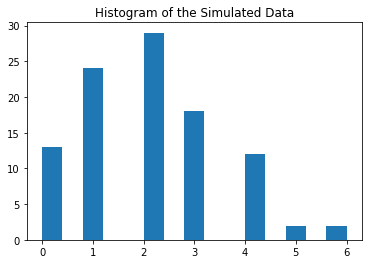

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Histogram of the sample.
plt.hist(y, bins=15, normed=False)
plt.title('Histogram of the Simulated Data')
plt.show()

Prior: Gamma Distribution
Let us consider a gamma prior distribution for the parameter $λ∼Γ(a,b)$. Recall that the density function for the gamma distribution is

$$f(λ)=\frac{b^a}{Γ(a)}λ^{a−1}e^{−bλ}$$
where a>0 is the shape parameter and b>0 is the rate parameter.

The expected value and variance of the gamma distribution is

$E(λ)=\frac{a}{b}$ and $Var(λ)=\frac{a}{b^2}$

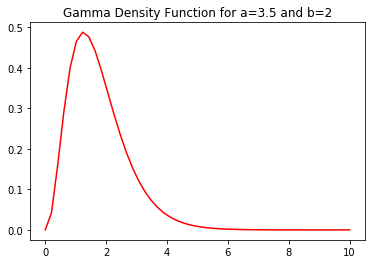

In [18]:
a = 3.5 # shape
b = 2 # rate = 1/scale

x = np.linspace(0,10)
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.title('Gamma Density Function for a={} and b={}'.format(a,b))
plt.show()

# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x,a=a,scale=1/b)

Likelihood
As the observations are independent the likelihood function is

$$f(y|λ)=\Pi_{i}^{n}−\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}$$
which simplifies to

$$f(y|λ)=\frac{e^{−nλ}λ\Sigma^n_{i=1}y_i}{\Pi^n_iy_i}$$

In [19]:
import scipy.special as sp

# Define the likelihood function.
def likelihood(lam,y):
    
    factorials = np.apply_along_axis(lambda x: sp.gamma(x+1),
                                     axis=0,
                                     arr=y)
    
    numerator = np.exp(-lam*y.size)*(lam**y.sum())
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator/denominator  

Posterior distribution for λ up to a constant
As we are just interested in the structure of the posterior distribution, up to a constant

$$f(λ|y)∝likelihood×prior∝f(y|λ)f(λ),$$
we see

$$f(λ|y)∝e^{−nλ}λ^{∑^n_{i=1}y_i}λ^{a−1}e^{−bλ}$$,
which can be written as

$$λ^{(∑^n_iy_i+a)−1}e^{−(n+b)λ}$$

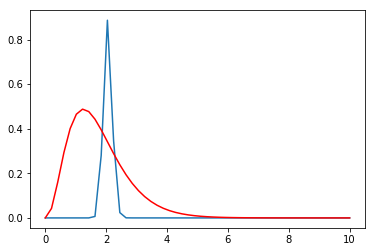

In [24]:
# Define the posterior distribution.
# (up to a constant)
def posterior_up_to_constant(lam,y):
    return likelihood(lam,y)*prior(lam)

# Plot of the prior and (scaled) posterior distribution
# for the parameter lambda.
#
# We multiply the posterior distrubution function
# by the amplitude factor 2.5e74 to make it comparable
# with the prior gamma distribution.
plt.plot(x, 2.5e74*posterior_up_to_constant(x,y))
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.show()

True posterior distribution for λ
In fact, as $f(λ|y)∝λ^{(∑^n_iy_i+a)−1}e^{−(n+b)λ}$, one verifies that the posterior distribution is again a gamma

$$f(λ|y)=Γ(∑_{i=1}^ny_i+a,n+b)$$
This means that the gamma and Poisson distribution form a conjugate pair.



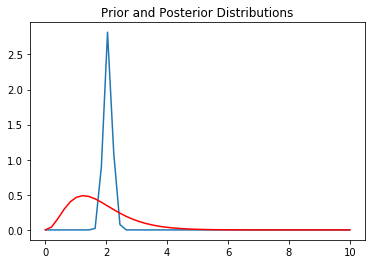

In [27]:
def posterior(lam,y):
    
    shape = a + y.sum()
    rate = b + y.size
    
    return ss.gamma.pdf(lam, shape, scale=1/rate)

plt.plot(x, posterior(x,y))
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.title('Prior and Posterior Distributions')
plt.show()

We indeed see how the posterior distribution is concentrated around the true parameter λ=2.

Note that the posterior mean is

$$\frac{∑^n_{i=1}y_i+a}{n+b}$$,
which can be written as the sum of two terms

$$\frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{∑^n_iy_i}{n}$$.
That is, it is a weighted average of the prior mean a/b and the sample average y¯. As n→∞, the posterior mean converges to $\bar{y}$.

In [28]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
shape/rate

2.053921568627451

## PyMC3 Syntax
Now we perform a MCMC simulation for the data described above. Note how easy is to write the model from the mathematical description.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lambda]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:02<00:00, 2636.17draws/s]


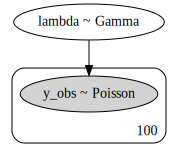

In [56]:
import pymc3 as pm
from pymc3 import model_to_graphviz
with pm.Model() as model:
    
    # Define the prior of the parameter lambda.
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=lam, observed=y)
    
    # Consider 2000 draws and 3 chains.
    trace = pm.sample(draws=2000, njobs=3)
model_to_graphviz(model)

If we do a trace plot we can see two results:

1. We see the simulated posterior distribution for 3 independent Markov Chains (so that, when combined, avoid the dependence on the initial point). The 3 different chains correspond to the color blue, green and orange.

2. The sample value of lambda for each iteration.

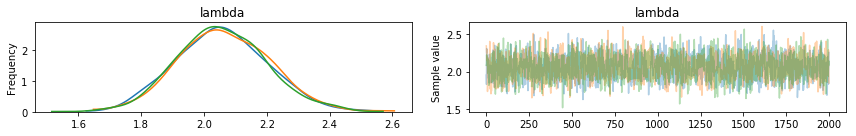

In [35]:
pm.traceplot(trace);

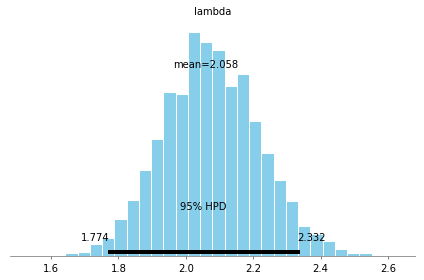

In [36]:
pm.plot_posterior(trace);

## Bayesian Hierarchical Modeling: A Chocolate Cookies Example.

Now we are going to treat a more complicated example which illustrated a hierarchical mdel.

The data
Assume there is a big factory producing chocolate cookies around the world. The cookies follow a unique recipe, but you want to study the chocolate chips distribution for cookies produced in 5 different locations.

1. On the one hand side you would assume that the distribution across the locations is similar, as they all come from a unique recipe. This is why you may not want to model each location separately.

2. On the other hand, in reality, as the locations are not exacly the same you might expect some differences between each location. This is why you may not want to model all locations at once.

To overcome these restrictions, a hierarchical can be a feasible approach.

In [42]:
import pandas as pd
import os
# os.chdir('/modelling_projects')

# We begin reading the data into a pandas dataframe.
cookies = pd.read_csv('cookies.dat', sep = ' ')

cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f46e6dc18>]],
      dtype=object)

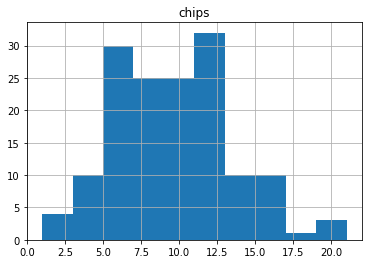

In [46]:
cookies.hist(column='chips', bins=10)

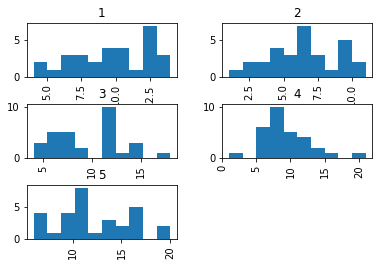

In [47]:
# Histogram distribution of chocolate chips
# for cookies in each location.
cookies.hist(column='chips', by='location', bins=10);

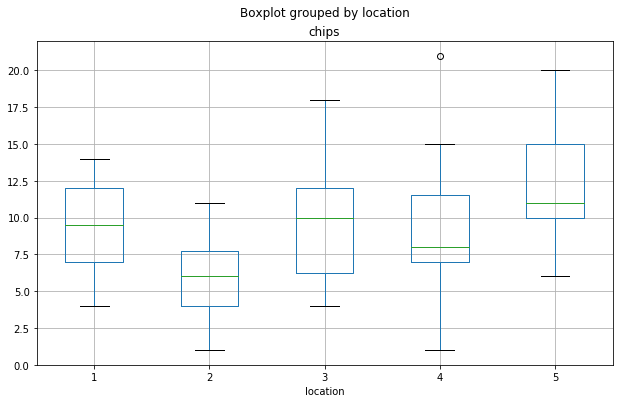

In [48]:
# Box plot for different locations.
cookies.boxplot(column='chips', by='location', figsize=(10,6));

## The model: Hierarchical Approach

### Hierarchical Model:
We model the chocolate chip counts by a Poisson distribution with parameter λ. Motivated by the example above, we choose a gamma prior.

$chips∼Poiss(λ)$                $λ∼Γ(a,b)$
#### Parametrization:
We parametrize the shape and scale of the gamma prior with the mean μ and variance $σ^2$.

$a=\frac{μ^2}{σ^2}$  $b=\frac{μ}{σ^2}$
Prior Distributions:
We further impose prior for these parameters

$μ∼Γ(2,1/5)$  and   $σ∼Exp(1)$

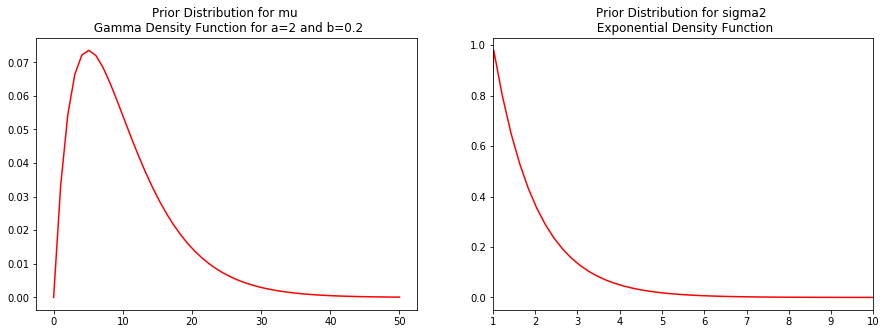

In [49]:
x = np.linspace(0,50)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x, ss.gamma.pdf(x,a=2,scale=5), 'r-')
plt.title('Prior Distribution for mu \n Gamma Density Function for a={} and b={}'.format(2,1/5))

plt.subplot(1, 2, 2)
x = np.linspace(0,10)
plt.plot(x, ss.expon.pdf(x,1), 'r-')
plt.title('Prior Distribution for sigma2 \n Exponential Density Function')
plt.xlim(1,10)


plt.show()

Let us write the model in PyMC3. Note how the syntax mimics the mathematical formulation.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lam, sigma, mu]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:04<00:00, 912.00draws/s] 


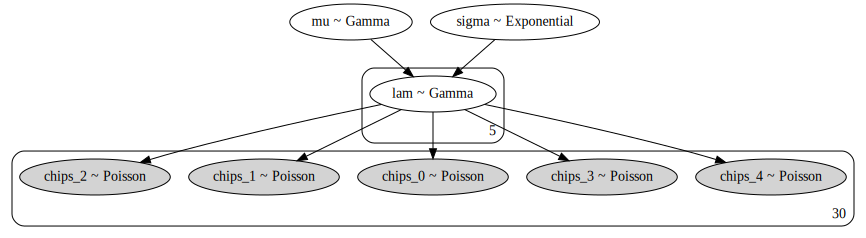

In [57]:
with pm.Model() as model:
    
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    
    # Parametrization for the shape parameter.
    alpha =  mu**2/sigma**2
    
    # Parametrization for the scale parameter.
    beta = mu/sigma**2
    
    # Prior distribution for lambda.
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, 
                   shape=cookies.location.values.max())
    
    # Likelihood function for the data.
    chips = [pm.Poisson('chips_{}'.format(i),lam[i], 
            observed=cookies[cookies.location==i+1].chips.values) 
            for i in range(cookies.location.values.max())] 
    
    
    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 1000, 3
    
    n_sim = n_draws*n_chains
    
    trace = pm.sample(draws=n_draws, njobs=n_chains) 
model_to_graphviz(model)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f3a72e198>,
      dtype=object)

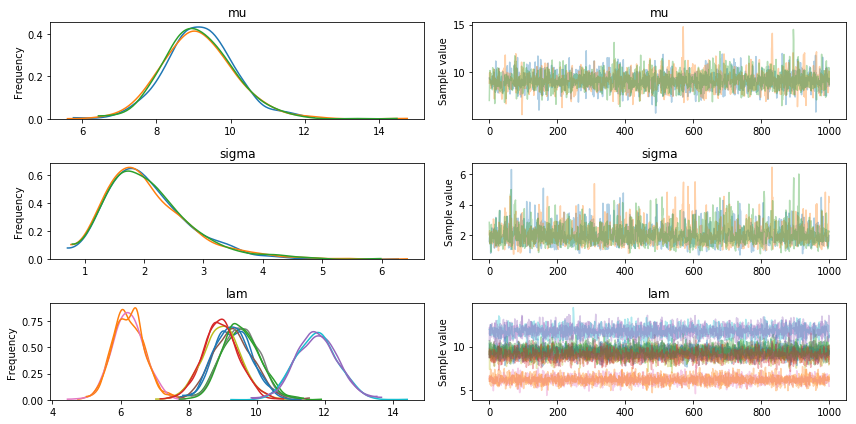

In [51]:
pm.traceplot(trace)

From the traceplot we see that the chains have converged. We can also have a detailed summary of the posterior distribution for each parameter:

In [52]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,9.146330,0.953601,0.015975,7.420373,11.166535,2915.599514,0.999717
sigma,2.070816,0.711317,0.013640,0.970204,3.555493,2262.847749,0.999740
lam__0,9.301411,0.560297,0.008058,8.318903,10.469021,4243.166758,0.999713
lam__1,6.229748,0.458927,0.008228,5.366420,7.142672,3133.220894,0.999553
lam__2,9.522470,0.547975,0.008811,8.497465,10.567538,3642.055670,0.999530
lam__3,8.950624,0.536776,0.008186,7.850560,9.972064,3867.025439,0.999812
lam__4,11.757604,0.612186,0.010620,10.649182,13.002128,3289.377959,0.999552


We can also see this visually.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f4b306fd0>,
      dtype=object)

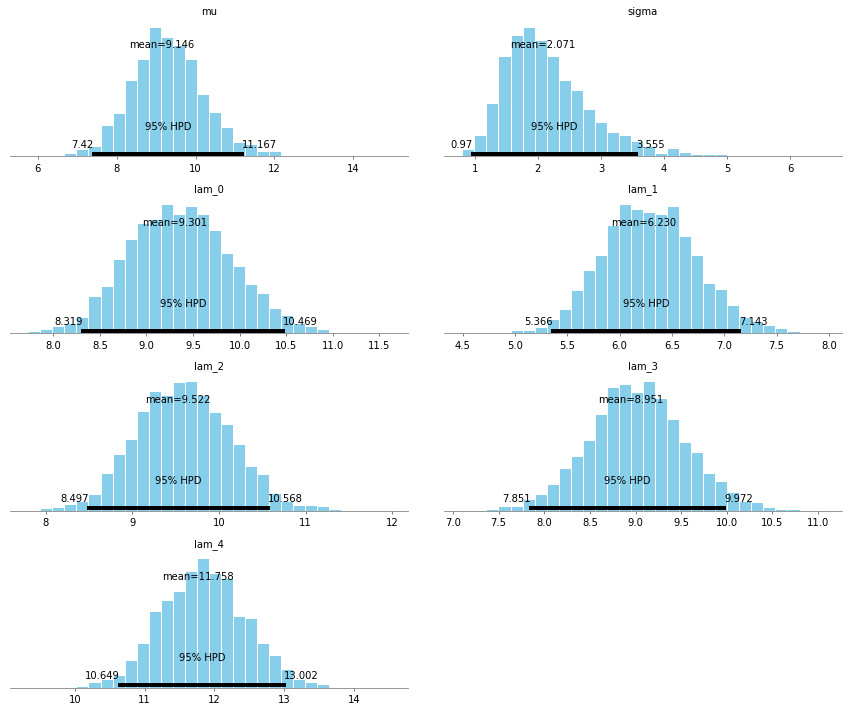

In [53]:
pm.plot_posterior(trace)

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [54]:
pm.gelman_rubin(trace)

{'mu': 0.9997173311996075,
 'sigma': 0.9997403358477721,
 'lam': array([0.9997126 , 0.99955322, 0.9995301 , 0.99981182, 0.99955153])}

We can also test for correlation between samples in the chains. We are aiming for zero auto-correlation to get “random” samples from the posterior distribution.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f3d7f5160>,
      dtype=object)

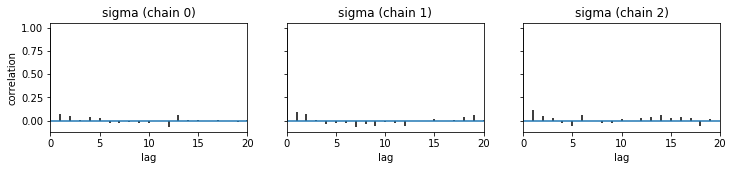

In [55]:
# Auto-correlation of the parameter sigma for the 3 chains.
pm.autocorrplot(trace, varnames=['sigma'], max_lag=20)

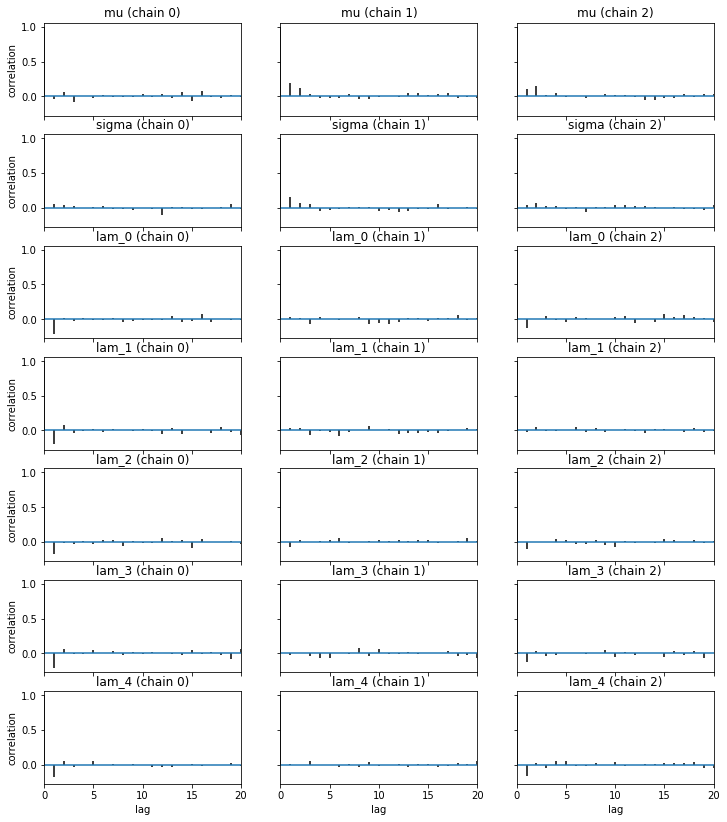

In [61]:
# We can also consider all the variables simultaneously. 
pm.autocorrplot(trace, max_lag=20);

In [62]:
pm.diagnostics.effective_n(trace)

{'mu': 2176.4619788129594,
 'sigma': 2229.755109176613,
 'lam': array([3851.02164838, 3255.62350063, 3925.85822063, 3881.94097957,
        3736.69199068])}

In [63]:
# Compute the mean of the simulation.
lambda_mean = np.apply_along_axis(np.mean, 0, trace['lam'])

# Compute for each sample the posterior mean.
cookies['yhat'] = cookies.location.apply(lambda x: lambda_mean[x-1])

# Compute the residuals.
cookies['resid'] = cookies.apply(lambda x: x.chips - x.yhat, axis=1)

cookies.head()

,chips,location,yhat,resid
0,12,1,9.290617,2.709383
1,12,1,9.290617,2.709383
2,6,1,9.290617,-3.290617
3,13,1,9.290617,3.709383
4,12,1,9.290617,2.709383


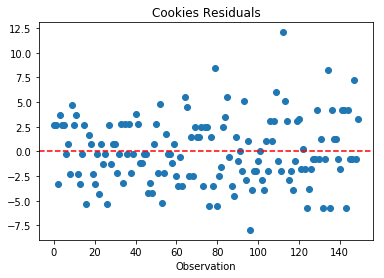

In [64]:
plt.scatter(x=cookies.index.values, y=cookies.resid.values)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('Cookies Residuals')
plt.xlabel('Observation');

Text(0.5, 1.0, 'Cookies Residuals')

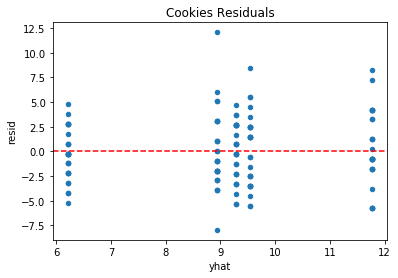

In [65]:
cookies.plot.scatter(x='yhat', y='resid');
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('Cookies Residuals')

Let us consider Location 1. We want, for example, to compute the posterior probability the next cookie in this location has less than 7 chips.

0.18233333333333332

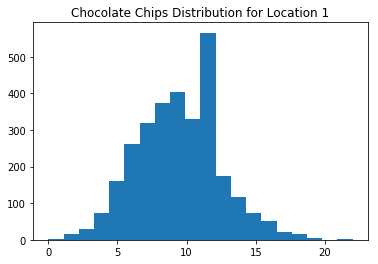

In [66]:
# We generate n_sim samples of a Poisson distribution for 
# each value for lam_0 (location 1) simulation..
y_pred_location_1 = np.random.poisson(lam=trace['lam'][:,0] , size=n_sim)

plt.figure()
plt.hist(y_pred_location_1, bins=20)
plt.title('Chocolate Chips Distribution for Location 1');

# Probability the next cookie in location has less than 7 chips.
(y_pred_location_1<7).astype(int).mean()

Now assume we want to open a new location. First, we want to compute the posterior probability that this new location has λ>15.

0.018333333333333333

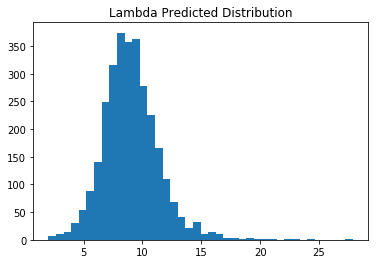

In [86]:
# Posterior distribution of for a an b 
# from the simulated values of mu and sigma2.
post_a = trace['mu']**2/trace['sigma']**2
post_b = trace['mu']/trace['sigma']**2

# We now generate samples of a gamma distribution 
# with these generated parameters of a and b.
lambda_pred_dist = np.random.gamma(post_a,1/post_b,n_sim) 

plt.figure()
plt.hist(lambda_pred_dist, bins=40)
plt.title('Lambda Predicted Distribution');

# Posterior probability a new location has lambda > 15.
(lambda_pred_dist>15).mean()

Now we answer a question at the next level of the hierarchical model. We want to calculate the posterior probability for a cookie produced in a new location to have more than 15 chocolate chips.

0.057666666666666665

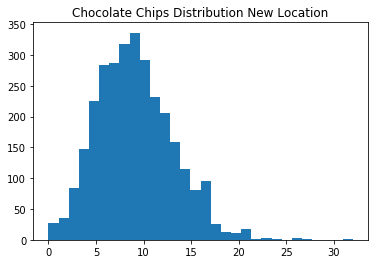

In [89]:
# Posterior distribution of the chips.
# Here we use the values of lambda obtained above.
cookies_pred_dist = np.random.poisson(lam=lambda_pred_dist, size=n_sim)

plt.figure()
plt.hist(cookies_pred_dist, bins=30)
plt.title('Chocolate Chips Distribution New Location');

# Posterior probability that a cookie produced 
# in a new location has more than 15 chocolate chips.
(cookies_pred_dist>15).mean()

In [104]:
test = [np.random.poisson(lam = x, size = 3000) for x in lambda_pred_dist]

In [105]:
temp = np.array(test)
(temp > 15).mean()

0.057445555555555555